In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_DIR = '/content/drive/MyDrive/image_dehazing_major_8th_sem/'
    platform = 'Google Colab'

except:
    ROOT_DIR = ''
    platform = 'Local machine'

dataset_path = f'{ROOT_DIR}Datasets/RESIDE-6K/train'
test_dataset_path = f'{ROOT_DIR}Datasets/RESIDE-6K/test'
model_save_path = f'{ROOT_DIR}models'
result_save_path = f'{ROOT_DIR}results'
infer_during_training_path = f'{ROOT_DIR}infer-during-training-pics'

print(f'Platform: {platform}')
dataset_path, test_dataset_path, model_save_path, result_save_path, infer_during_training_path

Platform: Local machine


('Datasets/RESIDE-6K/train',
 'Datasets/RESIDE-6K/test',
 'models',
 'results',
 'infer-during-training-pics')

In [2]:
try:
    import torchmetrics
    print('TorchMetrics already installed.')
    
except:
    !pip install torchmetrics
    print('TorchMetrics installed.')


c:\Users\dell\anaconda3\envs\azhan\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  RequestsDependencyWarning,


TorchMetrics already installed.


In [3]:
pip install torchvision 

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from PIL import Image
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import random

from tqdm.auto import tqdm

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

In [6]:
BATCH_SIZE = 16 if platform == 'Google Colab' else 4
TEST_BATCH_SIZE = 1
LR = 0.001
EPOCHS = 15
WANNA_TRAIN = False
WANNA_TEST = False
WANNA_SAVE = False
INFER_DURING_TRAINING = True

USE_PARTIALLY_TRAINED = False 
state_dict_name = 'LightClearNet_2024-03-30_22-21-25.pth'

In [7]:
class NormalizeTensor:
    def __call__(self, tensor):
        return tensor.clamp(-1, 1) * 0.5 + 0.5
    
normalize_tensor = NormalizeTensor()

img_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

tensor_to_img = transforms.Compose([
    transforms.ToPILImage(),
])

In [8]:
criterion = nn.L1Loss()
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

def visualize_pair(image1, image2, gap=20):
    image1 = tensor_to_img(image1) if isinstance(image1, torch.Tensor) else image1
    image2 = tensor_to_img(image2) if isinstance(image2, torch.Tensor) else image2

    new_image = Image.new('RGB', (image1.width + gap + image2.width, max(image1.height, image2.height)), color=(0, 0, 0, 0))
    new_image.paste(image1, (0, 0))
    new_image.paste(image2, (image1.width + gap, 0))

    return new_image

def visualize_random_pair_target(dataset):
    random_idx = random.randrange(len(dataset))
    print(f'Index: {random_idx}')

    return dataset.visualize_pair(random_idx)

def visualize_random_pair_pred(dataset, model, visualize_target=False, normalize=False):
    random_idx = random.randrange(len(dataset))
    print(dataset.inputs_folder + '/' + dataset.inputs_file_list[random_idx])

    input, target = [tensor.unsqueeze(0) for tensor in dataset[random_idx]]
    print(f'Image size: {[*input.shape]}')

    model.eval()
    with torch.inference_mode():
        pred = model(input)
    if normalize:
        pred = normalize_tensor(pred)

    loss = criterion(pred, target).item()
    psnr = psnr_metric(pred, target).item()
    ssim = ssim_metric(pred, target).item()

    print(f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%')

    if visualize_target:
        return visualize_pair(visualize_pair(input.squeeze(), pred.squeeze()), target.squeeze())
    return visualize_pair(input.squeeze(), pred.squeeze())

In [9]:
class HazyToClearDataset(Dataset):
    def __init__(self, root_loc, transform=None):
        self.root_loc = root_loc
        self.transform = transform

        self.inputs_folder = f'{self.root_loc}/hazy'
        self.targets_folder = f'{self.root_loc}/GT'
        self.inputs_file_list = sorted(os.listdir(self.inputs_folder))
        self.targets_file_list = sorted(os.listdir(self.targets_folder))

    def __len__(self):
        return len(self.inputs_file_list)

    def __getitem__(self, idx):
        input_loc = os.path.join(self.inputs_folder, self.inputs_file_list[idx])
        target_loc = os.path.join(self.targets_folder, self.targets_file_list[idx])

        input = Image.open(input_loc)
        target = Image.open(target_loc)

        if self.transform:
            input = self.transform(input).to(device)
            target = self.transform(target).to(device)

        return input, target

    def visualize_pair(self, idx):
        print(f'Input Image: {self.inputs_folder}/{self.inputs_file_list[idx]}')
        print(f'Target Image: {self.targets_folder}/{self.targets_file_list[idx]}')

        return visualize_pair(*self[idx])
    
    def index(self, image_name):
        return self.inputs_file_list.index(image_name)

In [10]:
dataset = HazyToClearDataset(dataset_path, transform=img_to_tensor)

iset = set(dataset.inputs_file_list)
tset = set(dataset.targets_file_list)

print((iset - tset, tset - iset))

len(dataset), random.choice(dataset)

(set(), set())


(6000,
 (tensor([[[0.7294, 0.7294, 0.7333,  ..., 0.7020, 0.7020, 0.7020],
           [0.7333, 0.7294, 0.7333,  ..., 0.7020, 0.7020, 0.7020],
           [0.7333, 0.7333, 0.7333,  ..., 0.7020, 0.6980, 0.6980],
           ...,
           [0.6863, 0.6863, 0.6824,  ..., 0.6471, 0.6510, 0.6510],
           [0.6863, 0.6824, 0.6824,  ..., 0.6549, 0.6549, 0.6549],
           [0.6824, 0.6824, 0.6824,  ..., 0.6549, 0.6549, 0.6549]],
  
          [[0.6902, 0.6902, 0.6941,  ..., 0.6588, 0.6549, 0.6549],
           [0.6941, 0.6902, 0.6941,  ..., 0.6588, 0.6549, 0.6549],
           [0.6941, 0.6941, 0.6941,  ..., 0.6588, 0.6549, 0.6549],
           ...,
           [0.6471, 0.6510, 0.6471,  ..., 0.6157, 0.6196, 0.6196],
           [0.6471, 0.6431, 0.6431,  ..., 0.6157, 0.6157, 0.6157],
           [0.6431, 0.6431, 0.6431,  ..., 0.6196, 0.6157, 0.6157]],
  
          [[0.6941, 0.6941, 0.6980,  ..., 0.6510, 0.6549, 0.6549],
           [0.6980, 0.6941, 0.6980,  ..., 0.6510, 0.6549, 0.6549],
           [0.6

Index: 3264
Input Image: Datasets/RESIDE-6K/train/hazy/3937.jpg
Target Image: Datasets/RESIDE-6K/train/GT/3937.jpg


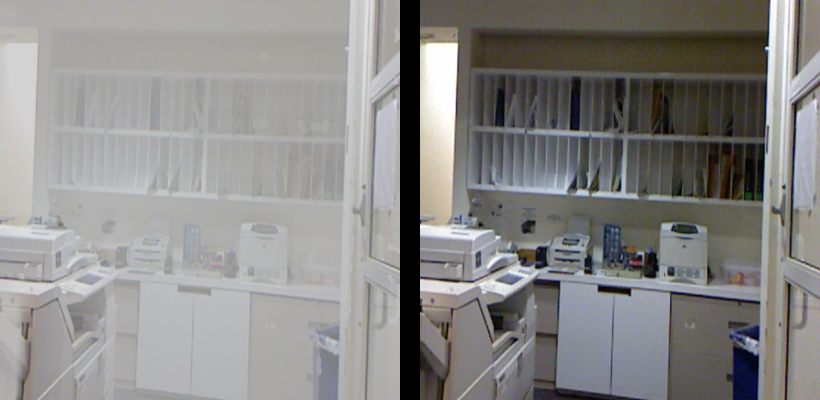

In [11]:
visualize_random_pair_target(dataset)

Input Image: Datasets/RESIDE-6K/train/hazy/166.jpg
Target Image: Datasets/RESIDE-6K/train/GT/166.jpg


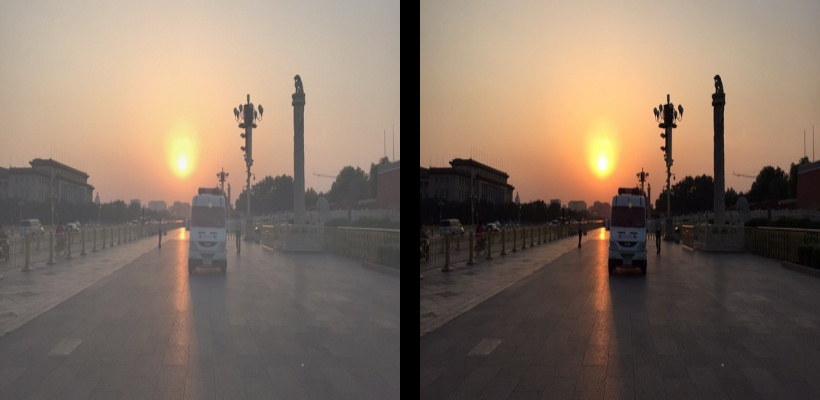

In [12]:
dataset.visualize_pair(734)

# dataset.index('407.jpg')

In [13]:
train_set, val_set = random_split(dataset, [5500, 500])

In [14]:
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
len(train_dataloader), len(val_dataloader)

(1375, 125)

In [16]:
class LightClearNetWithSkips(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)

        # Decoder
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        skip1 = x
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        skip2 = x
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = x + skip2
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = x + skip1
        x = F.sigmoid(self.dec_conv3(x))

        return x

In [17]:
class LightClearNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
class LightClearNetAir(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
model = LightClearNetWithSkips().to(device)

In [20]:
if USE_PARTIALLY_TRAINED:
    state_dict_loc = os.path.join(model_save_path, state_dict_name)
    state_dict = torch.load(state_dict_loc)
    model.load_state_dict(state_dict)

model.state_dict()

OrderedDict([('enc_conv1.weight',
              tensor([[[[-1.0012e-01,  1.4323e-01, -1.4677e-01],
                        [-4.5796e-02,  1.7660e-01,  1.2504e-01],
                        [-7.1682e-02,  1.3210e-01,  1.2006e-01]],
              
                       [[ 6.8917e-02,  9.2416e-02, -8.3455e-02],
                        [ 1.3306e-01, -1.1654e-01, -7.1554e-03],
                        [-7.3960e-02, -8.3271e-02, -6.0105e-02]],
              
                       [[ 1.2519e-01,  1.5417e-02,  4.4786e-02],
                        [ 6.2261e-02,  7.2214e-02,  1.3292e-01],
                        [-1.2857e-01, -1.1034e-02,  1.4552e-02]]],
              
              
                      [[[ 1.4569e-01, -3.3568e-02,  2.5158e-02],
                        [ 4.7079e-02, -8.3900e-02, -2.6868e-02],
                        [ 1.8178e-02,  1.3768e-01, -6.4566e-02]],
              
                       [[ 1.6756e-01, -9.6512e-02, -1.5306e-01],
                        [-1.1123e-02,  1.

In [21]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(dataset)[0].unsqueeze(0))
pred

C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[[[0.5383, 0.5439, 0.5396,  ..., 0.5446, 0.5408, 0.5146],
          [0.5561, 0.5576, 0.5436,  ..., 0.5503, 0.5485, 0.5171],
          [0.5598, 0.5661, 0.5506,  ..., 0.5606, 0.5598, 0.5278],
          ...,
          [0.5339, 0.5454, 0.5377,  ..., 0.5350, 0.5366, 0.5231],
          [0.5331, 0.5427, 0.5353,  ..., 0.5328, 0.5329, 0.5231],
          [0.5205, 0.5258, 0.5201,  ..., 0.5194, 0.5215, 0.5206]],

         [[0.5127, 0.5291, 0.5287,  ..., 0.5329, 0.5286, 0.5193],
          [0.5132, 0.5237, 0.5293,  ..., 0.5343, 0.5308, 0.5229],
          [0.5066, 0.5132, 0.5232,  ..., 0.5249, 0.5272, 0.5186],
          ...,
          [0.4947, 0.4985, 0.5010,  ..., 0.5032, 0.5050, 0.5009],
          [0.4910, 0.4938, 0.4925,  ..., 0.4936, 0.4972, 0.4981],
          [0.4890, 0.4871, 0.4867,  ..., 0.4855, 0.4907, 0.4936]],

         [[0.4870, 0.5079, 0.5138,  ..., 0.5177, 0.5153, 0.5222],
          [0.4613, 0.4783, 0.4951,  ..., 0.4951, 0.4927, 0.5164],
          [0.4616, 0.4783, 0.4932,  ..., 0

Datasets/RESIDE-6K/train/hazy/770.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.2504 | PSNR: 10.6135 | SSIM: 34.42%


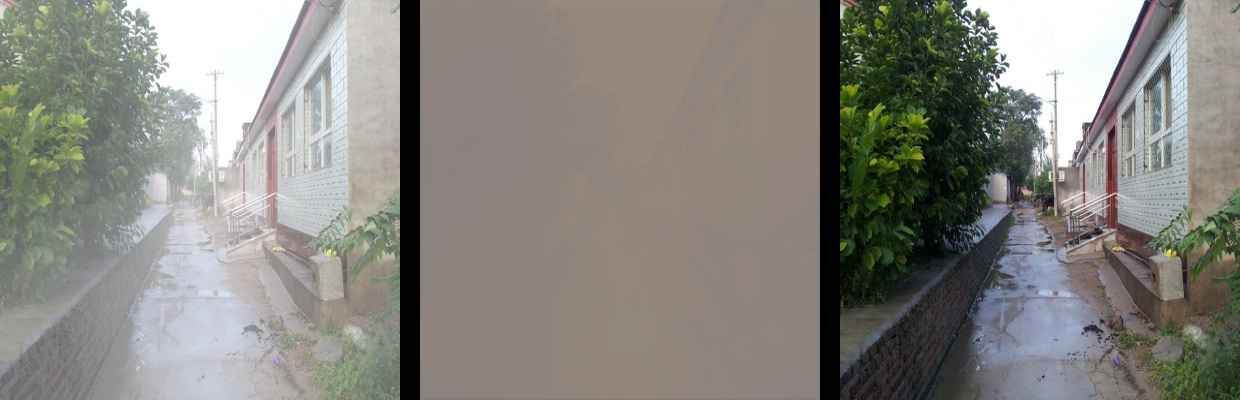

In [22]:
visualize_random_pair_pred(dataset, model, visualize_target=True)

In [23]:
criterion = nn.L1Loss()
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [24]:
baseline_perf = (0, 0, 0)

In [25]:
if WANNA_TRAIN and baseline_perf == (0, 0, 0):
    loss = 0
    psnr = 0
    ssim = 0

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(val_dataloader):
            pred = model(X)

            loss += criterion(pred, y).item()
            psnr += psnr_metric(pred, y).item()
            ssim += ssim_metric(pred, y).item()

    loss /= len(val_dataloader)
    psnr /= len(val_dataloader)
    ssim /= len(val_dataloader)

    print(f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%')
    baseline_perf = (loss, psnr, ssim)

baseline_perf

(0, 0, 0)

In [26]:
train_losses = []
val_losses = []
psnrs = []
ssims = []

In [27]:
train_losses, val_losses, psnrs, ssims

([], [], [], [])

In [28]:
# %%timeit -n 1 -r 1

if WANNA_TRAIN:
    prev_size = len(train_losses)
    if INFER_DURING_TRAINING:
        if train_losses:
            new_folder = f'{infer_during_training_path}/{sorted(os.listdir(infer_during_training_path))[-1]}'
        else:
            new_folder = f'{infer_during_training_path}/pics_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_-_{model.__class__.__name__}'
        os.makedirs(new_folder, exist_ok=True)
        image_idx = 734
        infer_X = dataset[image_idx][0].unsqueeze(0)

    for epoch in tqdm(range(EPOCHS)):
        train_loss = 0
        val_loss = 0
        psnr = 0
        ssim = 0

        model.train()
        for X, y in tqdm(train_dataloader):
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.inference_mode():
            for X, y in tqdm(val_dataloader):
                pred = model(X)
                loss = criterion(pred, y)

                val_loss += loss.item()
                psnr += psnr_metric(pred, y).item()
                ssim += ssim_metric(pred, y).item()

        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        psnr /= len(val_dataloader)
        ssim /= len(val_dataloader)

        print(f'Epoch: {epoch + prev_size}/{EPOCHS + prev_size} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim:.4f}')
        
        if INFER_DURING_TRAINING:
            with torch.inference_mode():
                pred = model(infer_X)
            inferred_image = tensor_to_img(pred.squeeze())

            infer_pic_path = f'{new_folder}/{epoch + prev_size}.jpg'
            inferred_image.save(infer_pic_path)
            print(infer_pic_path)
                
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        psnrs.append(psnr)
        ssims.append(ssim)

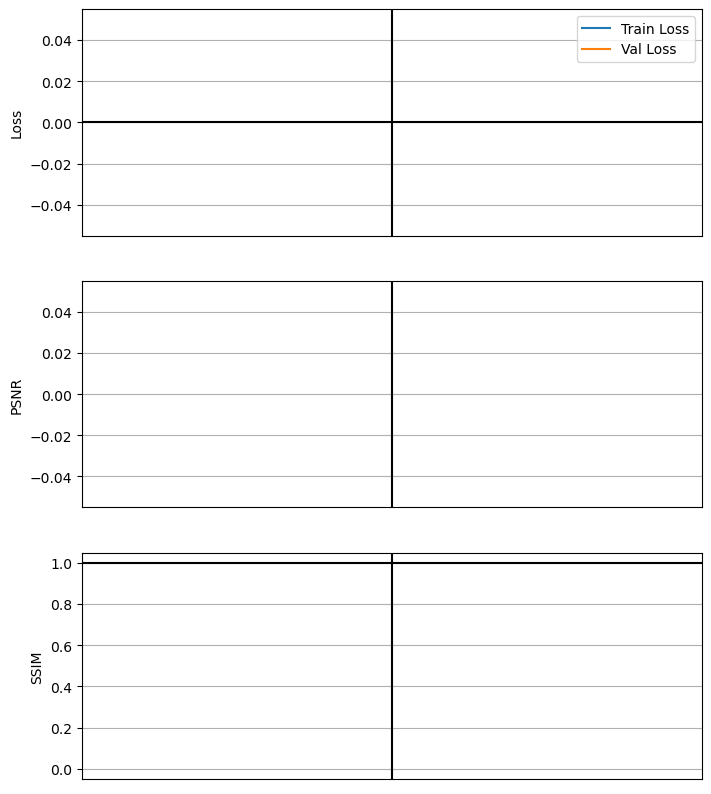

In [29]:
# train_losses = abs(torch.randn(100)) * 0.15
# val_losses = abs(torch.randn(100)) * 0.15
# psnrs = abs(torch.randn(100)) * 5 + 50
# ssims = abs(torch.randn(100)) * 0.5 + 0.5

plt.figure(figsize=(8, 10))
plt.title(f'{model.__class__.__name__} Training/Validation Plot')
plt.xlabel('Epoch')
plt.xticks(color='w')
plt.yticks(color='w')
plt.axis('off')

# ========== (1) ==========

plt.subplot(3, 1, 1)
plt.plot([baseline_perf[0]] + train_losses, label='Train Loss')
plt.plot([baseline_perf[0]] + val_losses, label='Val Loss')
plt.ylabel('Loss')

if len(train_losses) < 7:
    plt.xticks(range(len(train_losses)))
plt.grid(True)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.legend(loc='best')
# plt.ylim(-0.05, 1)

# ========== (2) ==========

plt.subplot(3, 1, 2)
plt.plot([baseline_perf[1]] + psnrs, label='PSNR', c='red')
plt.ylabel('PSNR')

if len(train_losses) < 7:
    plt.xticks(range(len(train_losses)))
plt.grid(True)
plt.axvline(0, color='black')

# ========== (3) ==========

plt.subplot(3, 1, 3)
plt.plot([baseline_perf[2]] + ssims, label='SSIM', c='green')
plt.ylabel('SSIM')

if len(train_losses) < 7:
    plt.xticks(range(len(train_losses)))
plt.grid(True)
plt.axhline(1, color='black')
plt.axvline(0, color='black')

plt.show()

In [30]:
test_dataset = HazyToClearDataset(test_dataset_path, transform=img_to_tensor)

iset = set(test_dataset.inputs_file_list)
tset = set(test_dataset.targets_file_list)

print((iset - tset, tset - iset))

len(test_dataset), random.choice(test_dataset)

(set(), set())


(1000,
 (tensor([[[0.5137, 0.5176, 0.5176,  ..., 0.4902, 0.4941, 0.4902],
           [0.5137, 0.5176, 0.5176,  ..., 0.4941, 0.4980, 0.4941],
           [0.5176, 0.5216, 0.5255,  ..., 0.4941, 0.5020, 0.4980],
           ...,
           [0.4510, 0.4588, 0.4667,  ..., 0.9725, 0.9765, 0.9765],
           [0.4431, 0.4471, 0.4588,  ..., 0.9490, 0.9569, 0.9647],
           [0.4392, 0.4431, 0.4549,  ..., 0.9412, 0.9490, 0.9529]],
  
          [[0.4980, 0.4980, 0.4980,  ..., 0.4471, 0.4431, 0.4314],
           [0.4980, 0.5020, 0.4980,  ..., 0.4510, 0.4471, 0.4353],
           [0.5020, 0.5059, 0.5059,  ..., 0.4510, 0.4471, 0.4353],
           ...,
           [0.3333, 0.3373, 0.3412,  ..., 0.9373, 0.9412, 0.9451],
           [0.3176, 0.3255, 0.3333,  ..., 0.9333, 0.9412, 0.9451],
           [0.3137, 0.3176, 0.3255,  ..., 0.9412, 0.9451, 0.9490]],
  
          [[0.5137, 0.5137, 0.5137,  ..., 0.3686, 0.3686, 0.3686],
           [0.5137, 0.5137, 0.5137,  ..., 0.3725, 0.3765, 0.3686],
           [0.5

Index: 889
Input Image: Datasets/RESIDE-6K/test/hazy/1759_0.8_0.12.jpg
Target Image: Datasets/RESIDE-6K/test/GT/1759_0.8_0.12.jpg


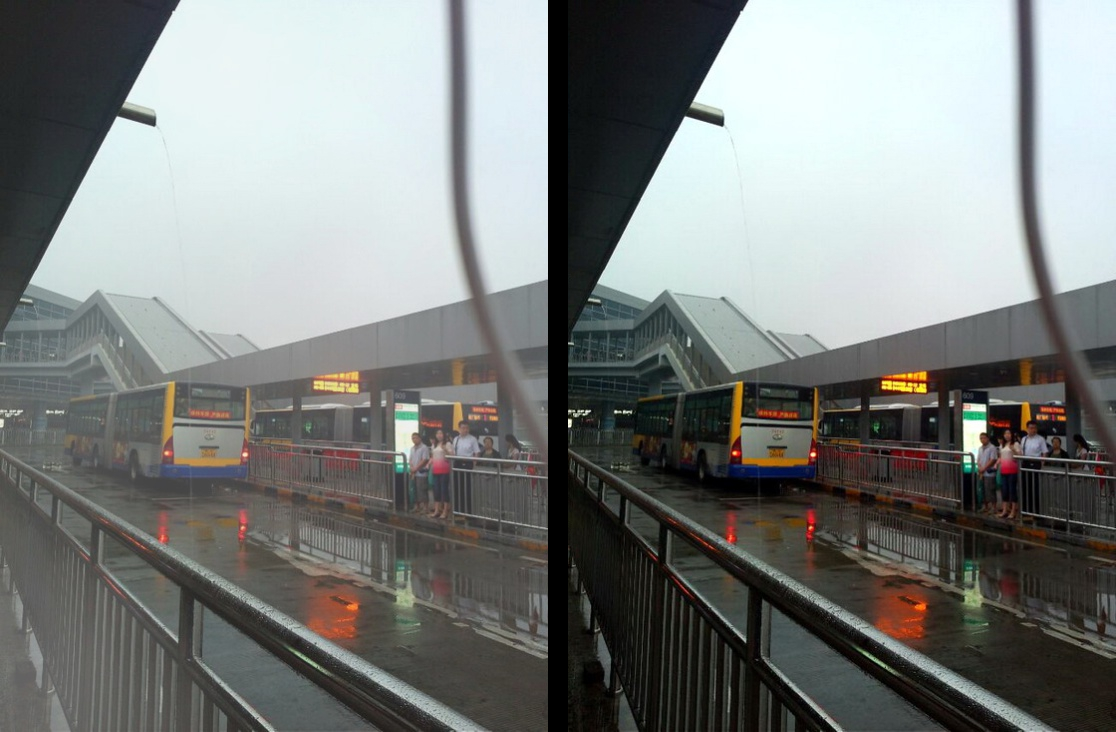

In [31]:
visualize_random_pair_target(test_dataset)

In [32]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(test_dataset)[0].unsqueeze(0))
pred

tensor([[[[0.5412, 0.5500, 0.5419,  ..., 0.5564, 0.5521, 0.5107],
          [0.5619, 0.5677, 0.5521,  ..., 0.5721, 0.5707, 0.5145],
          [0.5678, 0.5804, 0.5638,  ..., 0.5935, 0.5916, 0.5356],
          ...,
          [0.5667, 0.5832, 0.5685,  ..., 0.5741, 0.5730, 0.5324],
          [0.5645, 0.5742, 0.5576,  ..., 0.5635, 0.5575, 0.5320],
          [0.5334, 0.5390, 0.5309,  ..., 0.5353, 0.5397, 0.5323]],

         [[0.5157, 0.5346, 0.5347,  ..., 0.5525, 0.5407, 0.5315],
          [0.5165, 0.5272, 0.5333,  ..., 0.5475, 0.5354, 0.5280],
          [0.5067, 0.5143, 0.5212,  ..., 0.5268, 0.5219, 0.5143],
          ...,
          [0.5043, 0.5133, 0.5175,  ..., 0.5166, 0.5139, 0.5072],
          [0.4911, 0.4963, 0.4966,  ..., 0.4942, 0.4971, 0.4991],
          [0.4831, 0.4829, 0.4799,  ..., 0.4765, 0.4834, 0.4909]],

         [[0.4910, 0.5130, 0.5190,  ..., 0.5312, 0.5211, 0.5253],
          [0.4634, 0.4826, 0.4958,  ..., 0.4917, 0.4846, 0.5088],
          [0.4619, 0.4805, 0.4927,  ..., 0

In [33]:
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

len(test_dataloader)

1000

In [34]:
# %%timeit -n 1 -r 1

if WANNA_TEST:
    model.eval()

    loss = 0
    psnr = 0
    ssim = 0

    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            preds = model(X)

            loss += criterion(preds, y).item()
            psnr += psnr_metric(preds, y).item()
            ssim += ssim_metric(preds, y).item()

    loss /= len(test_dataloader)
    psnr /= len(test_dataloader)
    ssim /= len(test_dataloader)

    result = f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%'
    print(result)

    os.makedirs(result_save_path, exist_ok=True)
    result_file_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.txt'
    with open(os.path.join(result_save_path, result_file_name), 'w') as f:
        f.write(result)

Datasets/RESIDE-6K/test/hazy/1410_4.png
Image size: [1, 3, 460, 620]
L1 Loss: 0.2183 | PSNR: 11.8506 | SSIM: 58.24%


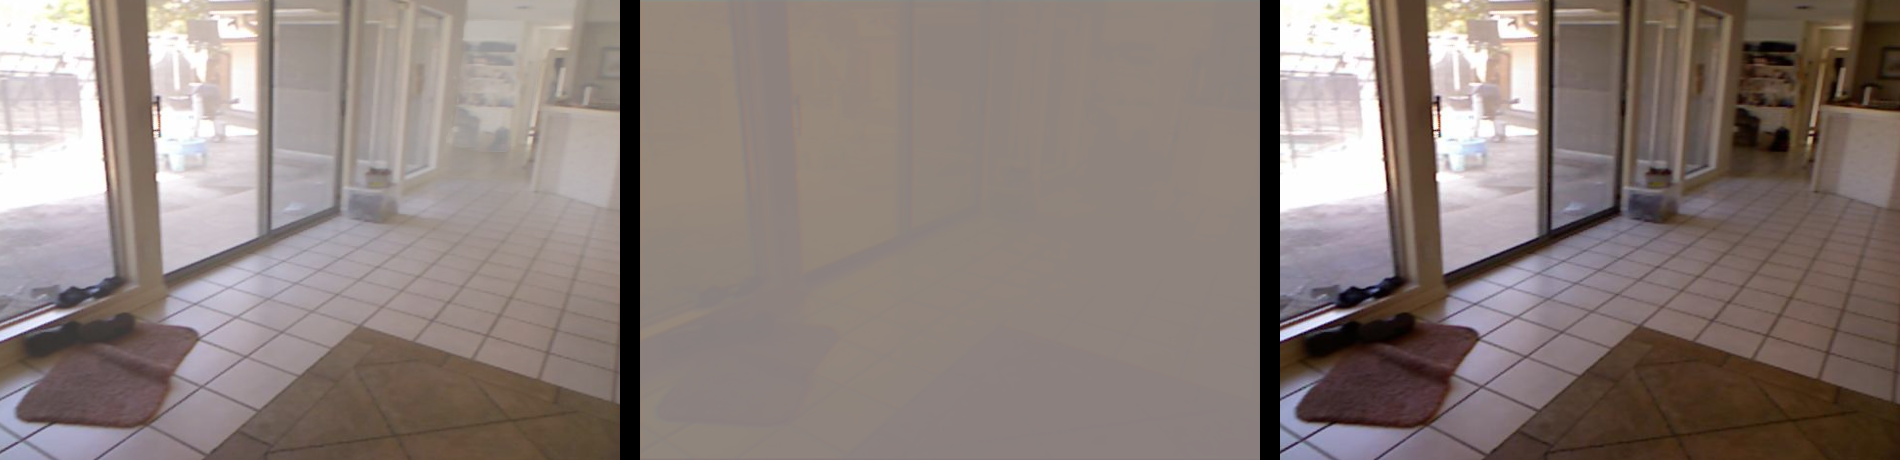

In [35]:
visualize_random_pair_pred(test_dataset, model, visualize_target=True)

In [36]:
if WANNA_SAVE:
    os.makedirs(model_save_path, exist_ok=True)
    model_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pth'
    torch.save(model.state_dict(), os.path.join(model_save_path, model_name))